In [192]:
import numpy as np
import matplotlib.pyplot as plt

x0 = 1
a = 0
M = 6
mu = -1

In [193]:
def analytic_probability(a:float, x0: float, M: float, mu: float) -> float:
    return np.exp(mu * (M - x0)) * (np.sinh((x0-a)*np.abs(mu)) / np.sinh((M-a)*np.abs(mu)))
                                    
true_prob = analytic_probability(a, x0, M, mu)
print(f"{true_prob:.2e}")

3.93e-05


In [194]:
def simulate_trajectory_with_path(start_pos, mu, target, dt=0.01):
    """Simulates trajectory until it reaches the target or hits 0."""
    x = start_pos
    trajectory = [x]
    max_x = x
    while x > 0:
        dx = mu * dt + np.sqrt(dt) * np.random.randn()
        x += dx
        trajectory.append(x)
        max_x = max(max_x, x)
        if max_x >= target:
            break  # Stop if target level is reached
    return max_x, trajectory

def classic_multilevel_splitting(n, x0, M, mu, num_levels=8):        
    levels = np.linspace(x0, M, num_levels + 1)[1:]  # Levels to reach
    particles = [{'max': None, 'trajectory': None} for _ in range(n)]
    probability = 1.0

    # Initialize particles to first level
    initial_target = levels[0]
    for i in range(n):
        max_x, trajectory = simulate_trajectory_with_path(x0, mu, initial_target)
        particles[i]['max'] = max_x
        particles[i]['trajectory'] = trajectory
        if max_x >= M:
            survivors = [p for p in particles if p['max'] >= current_level]

            # Update probability estimate
            conditional_prob = len(survivors) / n
            print(f"Intermediate prob: {conditional_prob:.2f}")
            probability *= conditional_prob
            return trajectory, conditional_prob  # Early exit if M is reached

    print(f"Start pos: {x0:.2f}, Intermediate M: {initial_target:.2f}")
    
    for i in range(len(levels) - 1):
        current_level = levels[i]
        next_level = levels[i + 1]

        # Select survivors (particles that reached current_level)
        survivors = [p for p in particles if p['max'] >= current_level]
        if not survivors:
            break  # No particles survived

        # Update probability estimate
        conditional_prob = len(survivors) / n
        print(f"Intermediate prob: {conditional_prob:.2f}")
        probability *= conditional_prob

        print(f"Start pos: {current_level:.2f}, Intermediate M: {next_level:.2f}")
        # Resample non-survivors from survivors
        for j in range(n):
            if particles[j]['max'] < current_level:
                parent = np.random.choice(survivors)
                parent_traj = parent['trajectory']

                # Find split point where parent first reached current_level
                split_idx = next(k for k, x in enumerate(parent_traj) if x >= current_level)
                start_pos = parent_traj[split_idx]

                # Simulate from split point to next_level
                new_max, new_traj = simulate_trajectory_with_path(start_pos, mu, next_level)

                # Combine trajectories and update particle
                combined_traj = parent_traj[:split_idx + 1] + new_traj[1:]
                particles[j]['max'] = max(new_max, current_level)
                particles[j]['trajectory'] = combined_traj

    # After the loop, calculate the final conditional probability
    final_survivors = [p for p in particles if p['max'] >= levels[-1]]
    if final_survivors:
        final_conditional_prob = len(final_survivors) / n
        print(f"final_conditional_prob prob: {final_conditional_prob:.2f}")
        probability *= final_conditional_prob

    # Return best trajectory and estimated probability
    max_particle = max(particles, key=lambda p: p['max'])
    return max_particle['trajectory'], probability

In [195]:
# Parameters
n = 5000

num_levels = (M - x0)

# Get trajectory and probability
if(num_levels >= 2):
    trajectory, probability = classic_multilevel_splitting(n, x0, M, mu, num_levels)
    time_points = np.arange(len(trajectory)) * 0.01
    
    # Print the probability
    print(f"Estimated probability of reaching M = {M}: {probability:.3e}")
    
else:
    print("Not Multisplitting")


Start pos: 1.00, Intermediate M: 2.00
Intermediate prob: 0.11
Start pos: 2.00, Intermediate M: 3.00
Intermediate prob: 0.12
Start pos: 3.00, Intermediate M: 4.00
Intermediate prob: 0.12
Start pos: 4.00, Intermediate M: 5.00
Intermediate prob: 0.12
Start pos: 5.00, Intermediate M: 6.00
final_conditional_prob prob: 0.12
Estimated probability of reaching M = 6: 2.378e-05


In [197]:
true_prob_list = []
estimated_prob_list = []

for M in range(3, 10):
    true_prob = analytic_probability(a, x0, M, mu)
    true_prob_list.append(true_prob)
    num_levels = (M - x0)
    
    # Get trajectory and probability
    if(num_levels >= 2):
        trajectory, probability = classic_multilevel_splitting(n, x0, M, mu, num_levels)
        time_points = np.arange(len(trajectory)) * 0.01

        # Print the probability
        print(f"Estimated probability of reaching M = {M}: {probability:.3e}")
        estimated_prob_list.append(probability)

    else:
        print("Not Multisplitting")

Start pos: 1.00, Intermediate M: 2.00
Intermediate prob: 0.11
Start pos: 2.00, Intermediate M: 3.00
final_conditional_prob prob: 0.12
Estimated probability of reaching M = 3: 1.356e-02
Start pos: 1.00, Intermediate M: 2.00
Intermediate prob: 0.11
Start pos: 2.00, Intermediate M: 3.00
Intermediate prob: 0.12
Start pos: 3.00, Intermediate M: 4.00
final_conditional_prob prob: 0.12
Estimated probability of reaching M = 4: 1.550e-03
Start pos: 1.00, Intermediate M: 2.00
Intermediate prob: 0.11
Start pos: 2.00, Intermediate M: 3.00
Intermediate prob: 0.12
Start pos: 3.00, Intermediate M: 4.00
Intermediate prob: 0.11
Start pos: 4.00, Intermediate M: 5.00
final_conditional_prob prob: 0.12
Estimated probability of reaching M = 5: 1.755e-04
Start pos: 1.00, Intermediate M: 2.00
Intermediate prob: 0.11
Start pos: 2.00, Intermediate M: 3.00
Intermediate prob: 0.12
Start pos: 3.00, Intermediate M: 4.00
Intermediate prob: 0.12
Start pos: 4.00, Intermediate M: 5.00
Intermediate prob: 0.12
Start pos: 

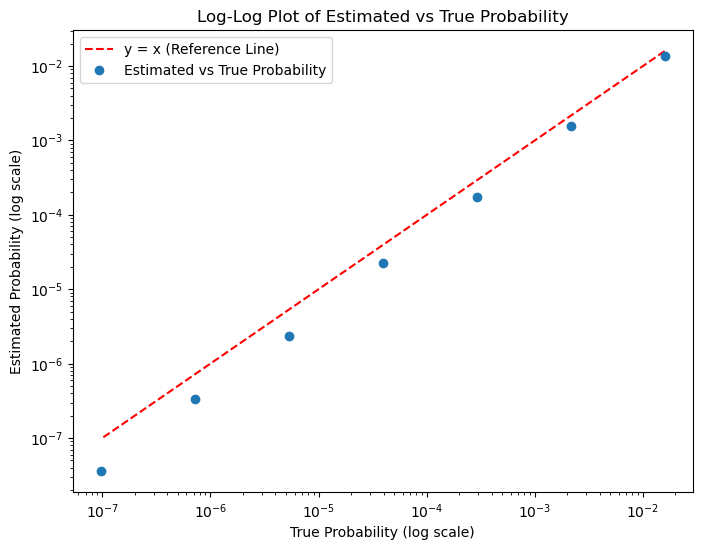

In [204]:
true_prob_list = np.array(true_prob_list)
estimated_prob_list = np.array(estimated_prob_list)

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(true_prob_list, true_prob_list, 'r--', label='y = x (Reference Line)')
plt.loglog(true_prob_list, estimated_prob_list, 'o', label='Estimated vs True Probability')

# Formatting
plt.xlabel('True Probability (log scale)')
plt.ylabel('Estimated Probability (log scale)')
plt.title('Log-Log Plot of Estimated vs True Probability')
plt.legend()
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()


array([ -4.14293163,  -6.14507794,  -8.14536806, -10.14540731,
       -12.14541263, -14.14541335, -16.14541344])

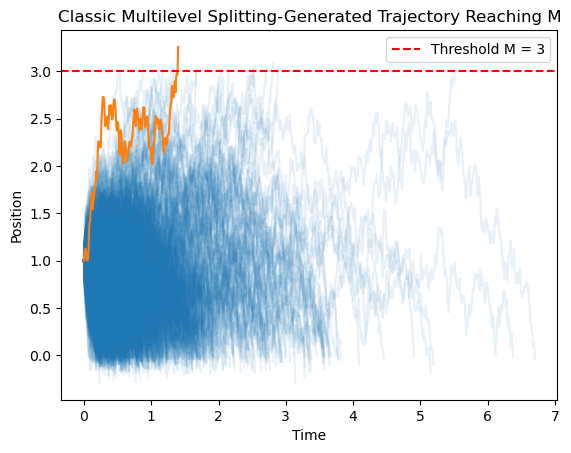

In [191]:
for i in range(1000):
    max_x, norm_traj = simulate_trajectory_with_path(x0, mu, M)
    norm_time = [i*0.01 for i in range(len(norm_traj))]

    plt.plot(norm_time, norm_traj, color = 'tab:blue', alpha = 0.1)
    
    
# Plot the trajectory
plt.plot(time_points, trajectory, color = 'tab:orange')
plt.axhline(M, color='r', linestyle='--', label=f'Threshold M = {M}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Classic Multilevel Splitting-Generated Trajectory Reaching M')

for level in levels:
    plt.axhline(level, color='b', linestyle='--', alpha = 0.1)
    
plt.legend()
plt.show()